# Classification Workflow: Pipelines!

## Objectives

- Formulate and implement an iterative modeling workflow
- Recognize how pipelines streamline the preprocessing and modeling process

## Why Pipeline?

Pipelines can keep our code neat and clean all the way from gathering & cleaning our data, to creating models & fine-tuning them!

**Advantages**: 
- Reduces complexity
- Convenient 
- Flexible 
- Can help prevent mistakes (like data leakage between train and test set) 

## Today's Agenda: 

We'll introduce pipelines in the lens of simplifying the whole classification workflow, top to bottom!

Our data: https://www.kaggle.com/c/cat-in-the-dat-ii

The goal is to classify the `target` column. 

The competition's main metric is ROC-AUC score! We can explore other metrics, but we should be sure to use that to evaluate our models.

### Steps:

1. Data Exploration
2. Define and structure data preprocessing steps
3. Run a `DummyClassifier` to create a model-less baseline, using a pipeline to combine the classifier with preprocessing steps
4. Run a `LogisticRegression` and compare results to the model-less baseline

If we have time, we'll keep iterating to improve!

In [1]:
# Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, plot_roc_curve, plot_precision_recall_curve
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [2]:
# Grab, then explore data
df = pd.read_csv("data/cat_in_the_dat2_train.csv", index_col='id')

In [3]:
# Define our X and y

X = df.drop(columns=['target'])
y = df['target']

# and train test split - to create our val holdout set!
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1,
                                                  random_state=0)

## Data Exploration

Explore the **training** data, checking out both numeric and categorical features.

We should run _at least_ one visualization to explore relationships among features!

In [4]:
# Your code here
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 540000 entries, 111903 to 305711
Data columns (total 23 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   bin_0   523875 non-null  float64
 1   bin_1   523788 non-null  float64
 2   bin_2   523842 non-null  float64
 3   bin_3   523821 non-null  object 
 4   bin_4   523757 non-null  object 
 5   nom_0   523586 non-null  object 
 6   nom_1   523710 non-null  object 
 7   nom_2   523725 non-null  object 
 8   nom_3   523642 non-null  object 
 9   nom_4   523754 non-null  object 
 10  nom_5   524031 non-null  object 
 11  nom_6   523727 non-null  object 
 12  nom_7   523823 non-null  object 
 13  nom_8   524017 non-null  object 
 14  nom_9   523725 non-null  object 
 15  ord_0   523528 non-null  float64
 16  ord_1   523778 non-null  object 
 17  ord_2   523694 non-null  object 
 18  ord_3   523891 non-null  object 
 19  ord_4   523867 non-null  object 
 20  ord_5   524095 non-null  object 
 21  day  

In [5]:
X_train.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
id,,,,,,,,,,,,,,,,,,,,,
111903,0.0,0.0,0.0,F,NaN,Red,Polygon,Lion,Finland,Bassoon,...,9dd6a02eb,6ce8fe5ee,3.0,Novice,Warm,c,O,NS,4.0,9.0
521435,0.0,1.0,0.0,F,N,Red,Triangle,Axolotl,Finland,Bassoon,...,679b63eff,a737a6428,2.0,Grandmaster,Freezing,m,A,gc,5.0,1.0
484488,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,India,Theremin,...,fbea9bb4a,b787c48f0,2.0,Master,Freezing,k,I,rl,2.0,8.0
529639,0.0,1.0,1.0,F,N,Red,Triangle,Hamster,Costa Rica,Bassoon,...,b72c0bbc2,NaN,1.0,Expert,Hot,e,P,WW,5.0,2.0
589943,0.0,NaN,0.0,T,N,Red,Triangle,Cat,Russia,Piano,...,b8e63cace,10695338e,2.0,Expert,Warm,a,N,LY,6.0,8.0


In [6]:
X_train.describe()

,bin_0,bin_1,bin_2,ord_0,day,month
count,523875.000000,523788.000000,523842.000000,523528.000000,523850.000000,523817.000000
mean,0.092245,0.185692,0.278842,1.947663,4.112578,6.372836
std,0.289372,0.388858,0.448430,0.853963,2.034344,3.459506
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,2.000000,3.000000
50%,0.000000,0.000000,0.000000,2.000000,5.000000,6.000000
75%,0.000000,0.000000,1.000000,3.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,3.000000,7.000000,12.000000


In [9]:
len(X_train.dropna())/len(X_train)

0.49672222222222223

In [14]:
X_train.dtypes

bin_0    float64
bin_1    float64
bin_2    float64
bin_3     object
bin_4     object
nom_0     object
nom_1     object
nom_2     object
nom_3     object
nom_4     object
nom_5     object
nom_6     object
nom_7     object
nom_8     object
nom_9     object
ord_0    float64
ord_1     object
ord_2     object
ord_3     object
ord_4     object
ord_5     object
day      float64
month    float64
dtype: object

In [19]:
X_train.describe(include='O')

,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_1,ord_2,ord_3,ord_4,ord_5
count,523821,523757,523586,523710,523725,523642,523754,524031,523727,523823,524017,523725,523778,523694,523891,523867,524095
unique,2,2,3,6,6,6,4,1220,1519,222,222,2218,5,6,15,26,190
top,F,N,Red,Triangle,Hamster,India,Theremin,423976253,ea8c5e181,c79d2197d,15f03b1f4,8f3276a6e,Novice,Freezing,n,N,Fl
freq,329627,281108,291147,147917,148355,148572,277705,867,728,4537,4518,523,144512,128452,64015,35891,9503


In [18]:
for col in X_train.columns:
    print(col)
    print(X_train[col].value_counts())
    print("*" * 20)

bin_0
0.0    475550
1.0     48325
Name: bin_0, dtype: int64
********************
bin_1
0.0    426525
1.0     97263
Name: bin_1, dtype: int64
********************
bin_2
0.0    377773
1.0    146069
Name: bin_2, dtype: int64
********************
bin_3
F    329627
T    194194
Name: bin_3, dtype: int64
********************
bin_4
N    281108
Y    242649
Name: bin_4, dtype: int64
********************
nom_0
Red      291147
Blue     185015
Green     47424
Name: nom_0, dtype: int64
********************
nom_1
Triangle     147917
Polygon      137268
Trapezoid    107633
Circle        94375
Square        23751
Star          12766
Name: nom_1, dtype: int64
********************
nom_2
Hamster    148355
Axolotl    137156
Lion       107592
Dog         94215
Cat         23676
Snake       12731
Name: nom_2, dtype: int64
********************
nom_3
India         148572
Costa Rica    136569
Russia        107921
Finland        94058
Canada         23700
China          12822
Name: nom_3, dtype: int64
**********

## Data Preprocessing

Let's outline our data processing strategy!

#### Discuss:

Some questions we can ask ourselves:

> How will we handle any null values? How will we handle any categorical features? What if our categorical features have 20+ unique values in each column? How will we scale our features?

- start with a simple imputer to fill with all "Unknown"
- categories with <20 uniques: one-hot-encode to make binary
- categories with >20 uniques ... ???
    - we could drop those columns
    - we could build indicator columns for the most common
    - we could frequency encode


In [21]:
used_cols = []
for col in X_train.columns:
    if len(X_train[col].unique()) < 30:
        used_cols.append(col)

In [22]:
used_cols

['bin_0',
 'bin_1',
 'bin_2',
 'bin_3',
 'bin_4',
 'nom_0',
 'nom_1',
 'nom_2',
 'nom_3',
 'nom_4',
 'ord_0',
 'ord_1',
 'ord_2',
 'ord_3',
 'ord_4',
 'day',
 'month']

In [23]:
X_train[used_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 540000 entries, 111903 to 305711
Data columns (total 17 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   bin_0   523875 non-null  float64
 1   bin_1   523788 non-null  float64
 2   bin_2   523842 non-null  float64
 3   bin_3   523821 non-null  object 
 4   bin_4   523757 non-null  object 
 5   nom_0   523586 non-null  object 
 6   nom_1   523710 non-null  object 
 7   nom_2   523725 non-null  object 
 8   nom_3   523642 non-null  object 
 9   nom_4   523754 non-null  object 
 10  ord_0   523528 non-null  float64
 11  ord_1   523778 non-null  object 
 12  ord_2   523694 non-null  object 
 13  ord_3   523891 non-null  object 
 14  ord_4   523867 non-null  object 
 15  day     523850 non-null  float64
 16  month   523817 non-null  float64
dtypes: float64(6), object(11)
memory usage: 74.2+ MB


Let's build a column transformer to define our data processing steps. Note that it's typically easiest to create list-like arrays of column names to match up with each processing step. Also - don't repeat columns! SKLearn's ColumnTransformer needs the lists of features it's processing to be mutually exclusive.

Reference: https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

In [24]:
# Your code here

binary_objects = ['bin_3', 'bin_4']
nom_objects = [col for col in used_cols if "nom_" in col]
ord_objects = ['ord_1', 'ord_2', 'ord_3', 'ord_4']

In [29]:
obj_cols = [col for col in used_cols if X_train[col].dtype == 'O']
obj_cols

['bin_3',
 'bin_4',
 'nom_0',
 'nom_1',
 'nom_2',
 'nom_3',
 'nom_4',
 'ord_1',
 'ord_2',
 'ord_3',
 'ord_4']

In [31]:
obj_transformer = Pipeline(steps=[
    ("obj_imputer", SimpleImputer(strategy = 'constant', fill_value='WHATEVER')),
    ('ohe', OneHotEncoder(drop=['WHATEVER']*len(obj_cols)))
])

In [30]:
num_cols = [col for col in used_cols if X_train[col].dtype != 'O']
num_cols

['bin_0', 'bin_1', 'bin_2', 'ord_0', 'day', 'month']

In [35]:
num_transformer = Pipeline(steps = [
    ('num_imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', MinMaxScaler())
])

In [36]:
preprocessor = ColumnTransformer(transformers=[
    ("num_trans", num_transformer, num_cols),
    ('obj_trans', obj_transformer, obj_cols)
])

In [37]:
preprocessor.fit_transform(X_train)

<540000x87 sparse matrix of type '<class 'numpy.float64'>'
	with 7327930 stored elements in Compressed Sparse Row format>

## Baseline Model

Let's find out how hard our problem is, by creating a model-less baseline!

If we use SKLearn's `DummyClassifier`, we can create our first full Pipeline!

Reference: https://scikit-learn.org/stable/modules/compose.html#pipeline

In [38]:
# Your code here

clf = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('modelless_baseline', DummyClassifier(strategy='prior'))
])

In [41]:
clf.fit(X_train, y_train)

train_preds = clf.predict(X_train)

In [42]:
train_preds

array([0, 0, 0, ..., 0, 0, 0])

In [44]:
y_train.value_counts()

0    438735
1    101265
Name: target, dtype: int64

In [45]:
cv_results = cross_validate(clf, X_train, y_train, cv=5)

In [47]:
cv_results['test_score']

array([0.81247222, 0.81247222, 0.81247222, 0.81247222, 0.81247222])

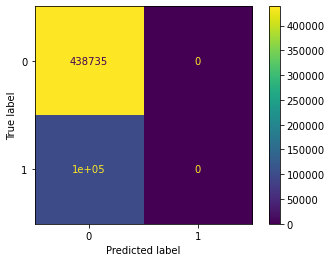

In [48]:
plot_confusion_matrix(clf, X_train, y_train)

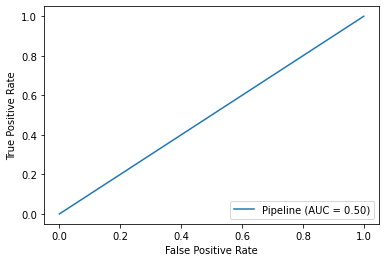

In [49]:
plot_roc_curve(clf, X_train, y_train)

#### Evaluate:

- 


## Logistic Regression

Let's build an initial logistic regression model, using the same preprocessing steps:

In [50]:
# Your code here
clf_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])

In [53]:
clf_lr.fit(X_train, y_train)

cv_results = cross_validate(clf_lr, X_train, y_train, scoring='roc_auc')

In [54]:
cv_results['test_score']

array([0.73592693, 0.73430216, 0.73870167, 0.73259738, 0.73553261])

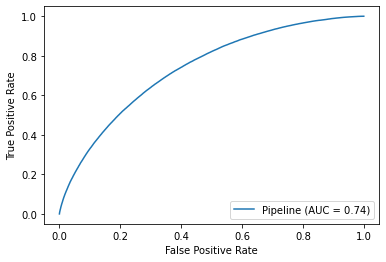

In [55]:
plot_roc_curve(clf_lr, X_train, y_train)

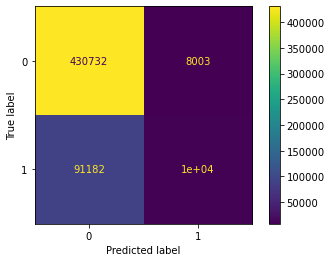

In [56]:
plot_confusion_matrix(clf_lr, X_train, y_train)

#### Evaluate:

- 


## Iterate

Let's either change something in our preprocessor, change something about our logistic regression model set up, or change the features we're using, then try again.

In [ ]:
# Your code here

#### Evaluate:

- 


## Validate

How does our best model (so far) perform on our holdout val set?

In [62]:
# Your code here
val_probs = clf_lr.predict_proba(X_val)[:,1]

In [63]:
roc_auc_score(y_val, val_probs)

0.7380504150035773

#### Discuss:

- 


## Resources

Check out Aurélien Geron's notebook of an [end-to-end ml project](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb) on his GitHub repo based around his book [_Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems (2nd ed)_](https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/)

## Level Up - What to do with too many options in categorical columns?


New library you can install with MORE encoding techniques, beyond one-hot encoding! https://contrib.scikit-learn.org/category_encoders/

- (these work within SKLearn pipelines, since they're written in the SKLearn style!)
